# Empresa de productos alimenticios.

Para este proyecto se estará trabajando en una empresa emergente que vende productos alimenticios. Se deberá de investigar el comportamiento del usuario para la app de la empresa del día 25 de julio del 2019 al 7 de agosto de 2019.<br>
Las actividades que realizaremos serán: <br>
1 Estudiar y comprobar datos.<br>
2 Estudiar el embudo de eventos.<br>
3 Estudiar los resultados del experimento.


In [1]:
# Importar las librerias necesarias para la realización del proyecto.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
from scipy.stats import shapiro
from scipy.stats import levene
import matplotlib.cm as cm
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest

Paso 1. Abrir el archivo de datos y leer la información general

In [2]:
# Cargar el archivo de datos en un DataFrame utilizando el separador '\t' para archivos CSV.

archivo = pd.read_csv('/Users/angelhdez/Documents/Tripleten/repositorios/Productos_alimenticios/logs_experiencia_usuario.csv', sep = '\t')

Paso 2. Preparar los datos para el análisis

In [3]:
data = archivo.copy()

In [4]:
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [5]:
# Cambiar el nombre de las columnas para facilitar su manipulación.

data.columns = ['evento', 'userId', 'fechahr', 'expId']

In [6]:
# Cambiar el formato de la columna 'fechahr' a datetime.

data['fechahr'] = pd.to_datetime(data['fechahr'], unit = 's') 

In [7]:
# Crear una nueva columna 'fecha' con la fecha sin la hora.

data['fecha'] = data['fechahr'].dt.date
data['fecha'] = pd.to_datetime(data['fecha'])

In [8]:
# Impresión de los primeros 5 registros del DataFrame.

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   evento   244126 non-null  object        
 1   userId   244126 non-null  int64         
 2   fechahr  244126 non-null  datetime64[ns]
 3   expId    244126 non-null  int64         
 4   fecha    244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [9]:
# Buscar valores nulos en el DataFrame.

data.isna().sum()

evento     0
userId     0
fechahr    0
expId      0
fecha      0
dtype: int64

In [10]:
# Buscar valores duplicados en el DataFrame.

print(data[data.duplicated()].head())
print(f"Número de filas duplicadas:", data.duplicated().sum())

                evento               userId             fechahr  expId  \
453   MainScreenAppear  5613408041324010552 2019-07-30 08:19:44    248   
2350  CartScreenAppear  1694940645335807244 2019-07-31 21:51:39    248   
3573  MainScreenAppear   434103746454591587 2019-08-01 02:59:37    248   
4076  MainScreenAppear  3761373764179762633 2019-08-01 03:47:46    247   
4803  MainScreenAppear  2835328739789306622 2019-08-01 04:44:01    248   

          fecha  
453  2019-07-30  
2350 2019-07-31  
3573 2019-08-01  
4076 2019-08-01  
4803 2019-08-01  
Número de filas duplicadas: 413


In [11]:
# Eliminar los valores duplicados del DataFrame.

datos = data.copy()

In [12]:
datos.drop_duplicates(inplace = True)
print(datos.info())

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   evento   243713 non-null  object        
 1   userId   243713 non-null  int64         
 2   fechahr  243713 non-null  datetime64[ns]
 3   expId    243713 non-null  int64         
 4   fecha    243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB
None


Paso 3. Estudiar y comprobar los datos


In [13]:
# ¿Cuántos eventos hay en los registros?

total_eventos = datos['evento'].count()
total_eventos
embudo = datos['evento'].value_counts().reset_index()
embudo.columns = ['evento', 'total']
embudo['porcentaje'] = embudo['total'] / total_eventos
embudo

,evento,total,porcentaje
0,MainScreenAppear,119101,0.488694
1,OffersScreenAppear,46808,0.192062
2,CartScreenAppear,42668,0.175075
3,PaymentScreenSuccessful,34118,0.139993
4,Tutorial,1018,0.004177


In [14]:
fig = px.funnel(embudo, 
    x = 'total', 
    y = 'evento',
    title = 'Embudo de eventos',
    labels = {'index': 'evento', 'value': 'Número de eventos'}
)

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', 'red']
fig.data[0].marker.color = colors[:len(fig.data[0].y)]
fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color = 'lightgray'

fig.update_layout(
    paper_bgcolor = 'black',
    plot_bgcolor = 'black',
    font_color = 'white')

In [15]:
# ¿Cuántos usuarios hay en los registros?

usuariosUnicos = datos['userId'].nunique()
print(f"Usuarios únicos:", usuariosUnicos)

Usuarios únicos: 7551


In [16]:
# Número de usuarios por evento.

usuariosUnicosPorEvento = datos.groupby('evento')['userId'].nunique().reset_index().sort_values(by = 'userId', ascending = False)

In [17]:
fig2 = px.funnel(usuariosUnicosPorEvento, 
    x = 'userId', 
    y = 'evento',
    title = 'Usuarios únicos por eventos',
    labels = {'index': 'evento', 'value': 'Número de eventos'}
)

colors2 = ['blue', 'green', 'red', 'purple', 'orange']
fig2.data[0].marker.color = colors2[: len(fig2.data[0].y)]
fig2.data[0].marker.line.width = 2
fig2.data[0].marker.line.color = 'lightgray'

fig2.update_layout(
    paper_bgcolor = 'black',
    plot_bgcolor = 'black',
    font_color = 'white')

In [18]:
# ¿Cuál es el promedio de eventos por usuario?

promedio_eventos = total_eventos / usuariosUnicos
print(f"Promedio de eventos por usuario:", round(promedio_eventos, 2))


Promedio de eventos por usuario: 32.28


In [19]:
# ¿Qué periodo de tiempo cubren los datos? ¿Cuál es la fecha más antigua y la más reciente?

print(datos['fechahr'].max())
print(datos['fechahr'].min())

2019-08-07 21:15:17
2019-07-25 04:43:36


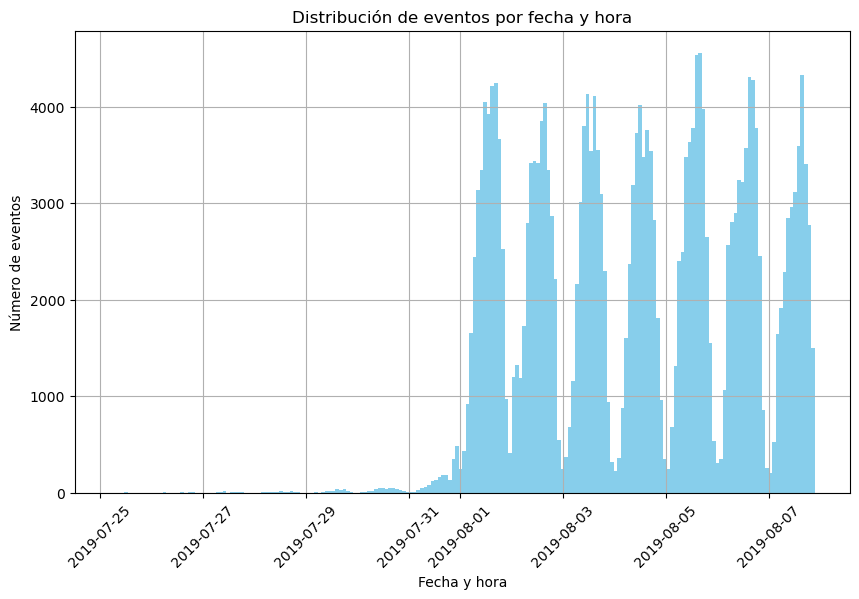

In [20]:
# ¿Cuántos días de datos tenemos?

plt.figure(figsize = (10, 6))
datos['fechahr'].hist(bins = 200, color = 'skyblue')
plt.title('Distribución de eventos por fecha y hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.xticks(rotation = 45)
plt.show()

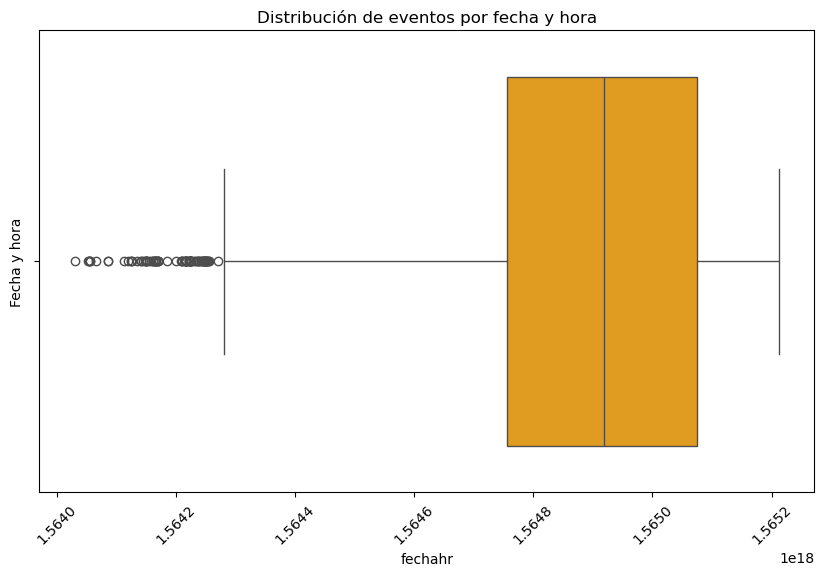

In [21]:
# ¿Cómo se ven los datos atípicos en la distribución de eventos por fecha y hora?

plt.figure(figsize = (10, 6))
sns.boxplot(x = datos['fechahr'].astype('int'), data = datos, color = 'orange')
plt.title('Distribución de eventos por fecha y hora')
plt.ylabel('Fecha y hora')
plt.xticks(rotation = 45)
plt.show()

In [22]:
# Se eliminan los datos atípicos de la distribución de eventos por fecha y hora, a paritir del mes de agosto.

agosto = datos[datos['fecha'] > pd.to_datetime('2019-07-31')]

In [23]:
agosto

,evento,userId,fechahr,expId,fecha
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [24]:
# ¿Cuál es la fecha minima y máxima de los datos de agosto?

print(agosto['fechahr'].min())
print(agosto['fechahr'].max())

2019-08-01 00:07:28
2019-08-07 21:15:17


In [25]:
# ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

usuariosUnicosAgosto = agosto['userId'].nunique()
print(f"Usuarios únicos:", usuariosUnicosAgosto)

usuariosPerdidos = usuariosUnicos - usuariosUnicosAgosto
print(f"Usuarios perdidos:", usuariosPerdidos)

total_eventos_agosto = agosto['evento'].count()
total_eventos_perdidos = total_eventos - total_eventos_agosto
print(f"Total de eventos perdidos:", total_eventos_perdidos)

Usuarios únicos: 7534
Usuarios perdidos: 17
Total de eventos perdidos: 2826


In [26]:
exp246 = agosto[agosto['expId'] == 246]
exp247 = agosto[agosto['expId'] == 247]
exp248 = agosto[agosto['expId'] == 248]
print("Número de usuarios unicos en el experimento 246:", exp246['userId'].nunique())
print("Número de usuarios unicos en el experimento 247:", exp247['userId'].nunique())
print("Número de usuarios unicos en el experimento 248:", exp248['userId'].nunique())

Número de usuarios unicos en el experimento 246: 2484
Número de usuarios unicos en el experimento 247: 2513
Número de usuarios unicos en el experimento 248: 2537


In [27]:
print(f"El % de usuarios únicos del experimento 246 corresponde al:", "{0: .4f}".format(exp246['userId'].nunique()/usuariosUnicosAgosto))
print(f"El % de usuarios únicos del experimento 247 corresponde al:","{0: .4f}".format(exp247['userId'].nunique()/usuariosUnicosAgosto))
print(f"El % de usuarios únicos del experimento 248 corresponde al:","{0: .4f}".format(exp248['userId'].nunique()/usuariosUnicosAgosto))

El % de usuarios únicos del experimento 246 corresponde al:  0.3297
El % de usuarios únicos del experimento 247 corresponde al:  0.3336
El % de usuarios únicos del experimento 248 corresponde al:  0.3367


Paso 4. Estudiar el embudo de eventos

In [28]:
# Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia. 
 
embudoAgosto = agosto['evento'].value_counts().reset_index()
embudoAgosto.columns = ['evento', 'total']
embudoAgosto['porcentaje'] = embudoAgosto['total']/total_eventos_agosto
embudoAgosto['eventos_fuera'] = embudoAgosto['total'] - embudoAgosto['total'].shift(1).fillna(0)
embudoAgosto['eventos_fuera'] = embudoAgosto['eventos_fuera'].abs()
embudoAgosto.loc[0, 'eventos_fuera'] = np.nan
print(embudoAgosto)

                    evento   total  porcentaje  eventos_fuera
0         MainScreenAppear  117328    0.487067            NaN
1       OffersScreenAppear   46333    0.192343        70995.0
2         CartScreenAppear   42303    0.175613         4030.0
3  PaymentScreenSuccessful   33918    0.140805         8385.0
4                 Tutorial    1005    0.004172        32913.0


In [29]:
fig3 = px.funnel(embudoAgosto, 
    x = ['total', 'eventos_fuera'], 
    y = 'evento',
    title = 'Embudo de eventos del mes de Agosto',
    labels = {'index': 'evento', 'value': 'Número de eventos'}
)

colors3 = ['white', 'blue', 'red', 'green', 'orange']
colors31 = ['blue', 'green', 'purple', 'orange', 'red']
fig3.data[0].marker.color = colors3[:len(fig3.data[0].y)]
fig3.data[0].marker.line.width = 2
fig3.data[0].marker.line.color = 'lightgray'
fig3.data[1].marker.color = colors31[:len(fig3.data[0].y)]
fig3.data[1].marker.line.width = 2
fig3.data[1].marker.line.color = 'lightgray'

fig3.update_layout(
    paper_bgcolor = 'black',
    plot_bgcolor = 'black',
    font_color = 'white')

In [30]:
# Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios.
# Calcula la proporción de usuarios que realizaron la acción al menos una vez.

embudoAgostoUsuarios = agosto.groupby('evento')['userId'].nunique().reset_index().sort_values(by = 'userId', ascending = False)
embudoAgostoUsuarios.columns = ['evento', 'usuarios_unicos']
embudoAgostoUsuarios['porcentaje'] = embudoAgostoUsuarios['usuarios_unicos']/usuariosUnicosAgosto
print(embudoAgostoUsuarios)

                    evento  usuarios_unicos  porcentaje
1         MainScreenAppear             7419    0.984736
2       OffersScreenAppear             4593    0.609636
0         CartScreenAppear             3734    0.495620
3  PaymentScreenSuccessful             3539    0.469737
4                 Tutorial              840    0.111495


¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.



Según los datos que hemos analizado lo primero que hacen los usuarios es ir a MainScreenAppear, en segundo lugar checar las ofertas en la página OfferScreenApper, seleccionan todos los artículos que van a comparar y proceden a ir a la pagina de CartScreenApper, hacen una inspeccion de sus articulos para verificar si no les falta alguno, proceden a realizar el pago y viajan a la página de PaymentScreenSuccessful, hay muchos usuarios que no visitan los tutoriales de como preparar los alimentos.<br>
No es necesario que sigan una secuencía ya que los usuarios vien podrían ingresar a la pagina de las ofertas antes que a la pagina de inicio por algún anuncio publicitario, o bien podrían ver primero un tutorial antes de decidirse a realizar el pago de los productos.

Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [31]:
# Calculo de usuarios que quedaron fuera de cada evento.

embudoAgostoUsuarios['usuarios_fuera'] = embudoAgostoUsuarios['usuarios_unicos'] - embudoAgostoUsuarios['usuarios_unicos'].shift().fillna(0)
embudoAgostoUsuarios['usuarios_fuera'] = embudoAgostoUsuarios['usuarios_fuera'].abs()
embudoAgostoUsuarios.loc[1, 'usuarios_fuera'] = np.nan
print(embudoAgostoUsuarios)

                    evento  usuarios_unicos  porcentaje  usuarios_fuera
1         MainScreenAppear             7419    0.984736             NaN
2       OffersScreenAppear             4593    0.609636          2826.0
0         CartScreenAppear             3734    0.495620           859.0
3  PaymentScreenSuccessful             3539    0.469737           195.0
4                 Tutorial              840    0.111495          2699.0


In [32]:
# Elaboración de grafico de embudo de usuarios en el mes de agosto.

fig4 = px.funnel(embudoAgostoUsuarios, 
    x = ['usuarios_unicos', 'usuarios_fuera'], 
    y = 'evento',
    title = 'Embudo de usuarios en el mes de Agosto',
    labels = {'index': 'evento', 'value': 'Número de usuarios'}
)

colors3 = ['white', 'blue', 'red', 'green', 'orange']
colors31 = ['blue', 'green', 'purple', 'orange', 'red']
fig4.data[0].marker.color = colors3[:len(fig4.data[0].y)]
fig4.data[0].marker.line.width = 2
fig4.data[0].marker.line.color = 'lightgray'
fig4.data[1].marker.color = colors31[:len(fig4.data[0].y)]
fig4.data[1].marker.line.width = 2
fig4.data[1].marker.line.color = 'lightgray'

fig4.update_layout(
    paper_bgcolor = 'black',
    plot_bgcolor = 'black',
    font_color = 'white')

¿En qué etapa pierdes más usuarios?<br>
<br>
De la pantalla de inicio a la de ofertas se pierden 2,826 usuarios únicos, y de la página de pago exitoso a los tutoriales se pierden 2,699 usuarios únicos.



¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [33]:
print(f"El procentaje de usuarios que hacen todo el viaje es de:", round((embudoAgostoUsuarios['porcentaje'][4])*100, 2), "%")

El procentaje de usuarios que hacen todo el viaje es de: 11.15 %


Paso 5. Estudiar los resultados del experimento

¿Cuántos usuarios hay en cada grupo?

In [34]:
print("Número de usuarios unicos en el experimento 246:", exp246['userId'].nunique())
print("Número de usuarios unicos en el experimento 247:", exp247['userId'].nunique())
print("Número de usuarios unicos en el experimento 248:", exp248['userId'].nunique())
print(f"El % de usuarios únicos del experimento 246 corresponde al:", round((exp246['userId'].nunique()/usuariosUnicosAgosto)*100, 2), "%")
print(f"El % de usuarios únicos del experimento 247 corresponde al:", round((exp247['userId'].nunique()/usuariosUnicosAgosto)*100, 2), "%")
print(f"El % de usuarios únicos del experimento 248 corresponde al:", round((exp248['userId'].nunique()/usuariosUnicosAgosto)*100, 2), "%")

Número de usuarios unicos en el experimento 246: 2484
Número de usuarios unicos en el experimento 247: 2513
Número de usuarios unicos en el experimento 248: 2537
El % de usuarios únicos del experimento 246 corresponde al: 32.97 %
El % de usuarios únicos del experimento 247 corresponde al: 33.36 %
El % de usuarios únicos del experimento 248 corresponde al: 33.67 %


Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [35]:
# Creación de una nueva columna 'dif_segundos' con la diferencia de tiempo en segundos entre eventos.
exp246 = exp246.copy()
exp247 = exp247.copy()
exp248 = exp248.copy()

exp246['dif_segundos'] = exp246.groupby('userId')['fechahr'].diff().dt.total_seconds()
exp247['dif_segundos'] = exp247.groupby('userId')['fechahr'].diff().dt.total_seconds()
exp248['dif_segundos'] = exp248.groupby('userId')['fechahr'].diff().dt.total_seconds()

In [36]:
muestra246 = exp246.groupby('userId')['fechahr'].diff().dt.total_seconds()
muestra247 = exp247.groupby('userId')['fechahr'].diff().dt.total_seconds()
muestra248 = exp248.groupby('userId')['fechahr'].diff().dt.total_seconds()

muestra246 = muestra246.dropna()
muestra247 = muestra247.dropna()
muestra248 = muestra248.dropna()

In [37]:
# Elaboración de una función que nos permita verificar la normalidad de los datos.

def checar_normalidad(datos):
    test_stats_normality, p_value_normality = st.shapiro(datos)
    print("p value:%.05f" % p_value_normality)
    if p_value_normality < 0.05:
        print("No se puede asumir normalidad")
    else:
        print("Se puede asumir normalidad")

In [38]:
checar_normalidad(muestra246)

p value:0.00000
No se puede asumir normalidad


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76818.



In [39]:
checar_normalidad(muestra247)

p value:0.00000
No se puede asumir normalidad


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 74509.



In [40]:
checar_normalidad(muestra248)

p value:0.00000
No se puede asumir normalidad


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 82026.



In [41]:
exp246['dif_segundos'].mean()

9894.854526282903

In [42]:
exp246

,evento,userId,fechahr,expId,fecha,dif_segundos
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,NaN
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,32.0
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,55.0
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,3.0
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01,88.0
...,...,...,...,...,...,...
244120,MainScreenAppear,5746969938801999050,2019-08-07 21:12:11,246,2019-08-07,16.0
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,240.0
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,152.0
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,15.0


In [43]:
umbral = 9894.85

In [44]:
# Creación de una función para contar los écitos y el tamaño de la muestra.

def contar_exitos (muestra, umbral):
    # Contar los éxitos (valores mayores al umbral)
    exitos = (muestra > umbral).sum()
    return exitos, len(muestra)

In [45]:
x1, n1 = contar_exitos(muestra246, umbral)
x2, n2 = contar_exitos(muestra247, umbral)
x3, n3 = contar_exitos(muestra248, umbral)

In [46]:
# Se realiza la prueba de proporciones entre las muestras
# Comparar muestra246 y muestra247.
count_12 = [x1, x2]
nobs_12 = [n1, n2]
z_stat_12, p_value_12 = proportions_ztest(count_12, nobs_12)

# Comparar muestra246 y muestra248.
count_13 = [x1, x3]
nobs_13 = [n1, n3]
z_stat_13, p_value_13 = proportions_ztest(count_13, nobs_13)

# Comparar muestra247 y muestra248.
count_23 = [x2, x3]
nobs_23 = [n2, n3]
z_stat_23, p_value_23 = proportions_ztest(count_23, nobs_23)

print(f"Comparación muestra246 vs muestra247:")
print(f"Estadístico Z: {z_stat_12}, Valor p: {p_value_12}\n")

print(f"Comparación muestra246 vs muestra248:")
print(f"Estadístico Z: {z_stat_13}, Valor p: {p_value_13}\n")

print(f"Comparación muestra247 vs muestra248:")
print(f"Estadístico Z: {z_stat_23}, Valor p: {p_value_23}\n")

Comparación muestra246 vs muestra247:
Estadístico Z: -4.8664929885297346, Valor p: 1.1359595164588794e-06

Comparación muestra246 vs muestra248:
Estadístico Z: 2.3718407079466726, Valor p: 0.017699719624097797

Comparación muestra247 vs muestra248:
Estadístico Z: 7.30205056757418, Valor p: 2.834147050497471e-13



In [47]:
alpha = 0.05
if p_value_12 < alpha:
    print(f"Rechazamos la hipótesis nula, las proporciones no son iguales.")
else:
    print(f"No podemos rechazar la hipótesis nula, las proporciones son iguales.")

Rechazamos la hipótesis nula, las proporciones no son iguales.


Se realizaron dos pruebas una con el umbral de 10 segundos y otra de 30 segundos y en ambas se tuvo que rechazar la hipótesis nula debido a que las proporciones no son iguales, de igual manera se realizo una con el promedio 9894.85 y se tuvo que rechazar la hipotesis nula.

In [48]:
# Función de prueba estadística para comparar si existe diferencia significativa entre los tiempos de los experimentos(mannwhitneyu).

def checar_diferencias_estadisticas_significativas(datos1, datos2):
    
    u_stats, p_value = st.mannwhitneyu(datos1, datos2)
    print(f'Estadistico U: {u_stats}')
    print(f'p-value: {p_value}')
    if p_value < 0.05:
        print('Existen diferencias estadisticamente significativas entre los grupos.')
    else:
        print('No existen diferencias estadisticamente significativas entre los grupos.')

In [49]:
checar_diferencias_estadisticas_significativas(muestra246, muestra247)

Estadistico U: 2763932369.5
p-value: 9.15209883991746e-31
Existen diferencias estadisticamente significativas entre los grupos.


In [50]:
experimento246 = exp246.dropna()
experimento247 = exp247.dropna()
experimento248 = exp248.dropna()

In [51]:
def procesar_datos(datos):
    # Paso 1: Agrupar por 'evento' y contar los 'userId' únicos.
    embudo = datos.groupby('evento')['userId'].nunique().reset_index()
    
    # Paso 2: Ordenar por la columna 'userId' de forma descendente.
    embudo = embudo.sort_values(by = 'userId', ascending = False)
    
    # Paso 3: Renombrar las columnas.
    embudo.columns = ['evento', 'usuarios_unicos']
    
    # Paso 4: Calcular el porcentaje de usuarios únicos.
    embudo['porcentaje'] = round((embudo['usuarios_unicos'] / datos['userId'].nunique())*100, 2)
    
    # Paso 5: Calcular la cantidad de usuarios que no pasaron de una etapa a otra.
    embudo['usuarios_fuera'] = embudo['usuarios_unicos'] - embudo['usuarios_unicos'].shift().fillna(0)
    embudo['usuarios_fuera'] = embudo['usuarios_fuera'].abs()
    
    return embudo

In [52]:
procesar_datos(experimento246)

,evento,usuarios_unicos,porcentaje,usuarios_fuera
1,MainScreenAppear,2395,97.83,2395.0
2,OffersScreenAppear,1535,62.70,860.0
0,CartScreenAppear,1264,51.63,271.0
3,PaymentScreenSuccessful,1195,48.82,69.0
4,Tutorial,43,1.76,1152.0


In [53]:
procesar_datos(experimento247)

,evento,usuarios_unicos,porcentaje,usuarios_fuera
1,MainScreenAppear,2417,97.74,2417.0
2,OffersScreenAppear,1513,61.18,904.0
0,CartScreenAppear,1238,50.06,275.0
3,PaymentScreenSuccessful,1157,46.79,81.0
4,Tutorial,43,1.74,1114.0


In [54]:
procesar_datos(experimento248)

,evento,usuarios_unicos,porcentaje,usuarios_fuera
1,MainScreenAppear,2424,97.19,2424.0
2,OffersScreenAppear,1523,61.07,901.0
0,CartScreenAppear,1229,49.28,294.0
3,PaymentScreenSuccessful,1174,47.07,55.0
4,Tutorial,47,1.88,1127.0


In [55]:
checar_diferencias_estadisticas_significativas(experimento246['dif_segundos'], experimento247['dif_segundos'])

Estadistico U: 2763932369.5
p-value: 9.15209883991746e-31
Existen diferencias estadisticamente significativas entre los grupos.


In [56]:
checar_diferencias_estadisticas_significativas(experimento246['dif_segundos'], experimento248['dif_segundos'])

Estadistico U: 3113389293.0
p-value: 4.677242456686569e-05
Existen diferencias estadisticamente significativas entre los grupos.


In [57]:
checar_diferencias_estadisticas_significativas(experimento247['dif_segundos'], experimento248['dif_segundos'])

Estadistico U: 3126030895.5
p-value: 3.615170339938529e-15
Existen diferencias estadisticamente significativas entre los grupos.


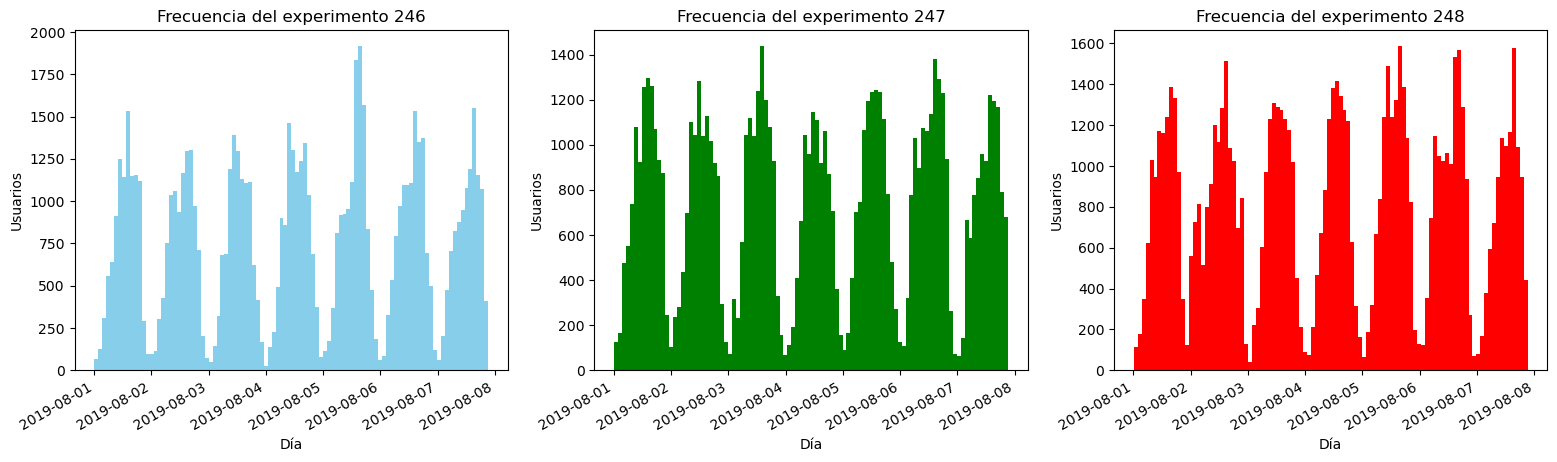

In [58]:
fig, ax = plt.subplots(1,3, figsize = (19, 5))

ax[0].hist(experimento246['fechahr'], bins = 100, color = 'skyblue')
ax[0].set(title = 'Frecuencia del experimento 246', xlabel = 'Día', ylabel = 'Usuarios')
ax[1].hist(experimento247['fechahr'], bins = 100, color = 'green')
ax[1].set(title = 'Frecuencia del experimento 247', xlabel = 'Día', ylabel = 'Usuarios')
ax[2].hist(experimento248['fechahr'], bins = 100, color = 'red')
ax[2].set(title = 'Frecuencia del experimento 248', xlabel = 'Día', ylabel = 'Usuarios')
fig.autofmt_xdate(rotation = 30)
plt.show()

En base a las pruebas estadisticas realizadas se puede llegar a la conclusión de que no se tomaron las muestras de los grupos correctamente, ya que existen diferencias significativas entre los grupos de datos.

In [59]:
# Corrección del alpha mediante el método Sidak.

alpha_corrected = 1 - (1 - 0.05) ** (1 / 3)

In [60]:
# Función de prueba estadística para comparar si existe diferencia significativa entre los tiempos de los experimentos(mannwhitneyu).


def checar_diferencias_estadisticas_significativas_alpha_corregido(datos1, datos2):
    
    u_stats, p_value = st.mannwhitneyu(datos1, datos2)
    print(f'Estadistico U: {u_stats}')
    print(f'p-value: {p_value}')
    if p_value < alpha_corrected:
        print('Existen diferencias estadisticamente significativas entre los grupos.')
    else:
        print('No existen diferencias estadisticamente significativas entre los grupos.')

In [61]:
checar_diferencias_estadisticas_significativas_alpha_corregido(experimento246['dif_segundos'], experimento247['dif_segundos'])

Estadistico U: 2763932369.5
p-value: 9.15209883991746e-31
Existen diferencias estadisticamente significativas entre los grupos.


In [62]:
checar_diferencias_estadisticas_significativas_alpha_corregido(experimento246['dif_segundos'], experimento248['dif_segundos'])

Estadistico U: 3113389293.0
p-value: 4.677242456686569e-05
Existen diferencias estadisticamente significativas entre los grupos.


In [63]:
checar_diferencias_estadisticas_significativas_alpha_corregido(experimento247['dif_segundos'], experimento248['dif_segundos'])

Estadistico U: 3126030895.5
p-value: 3.615170339938529e-15
Existen diferencias estadisticamente significativas entre los grupos.


Se le realizo la corrección del alpha para las pruebas estadísticas mediante el método Sidak y se puede llegar a la conclusión de que no se tomaron las muestras de los grupos correctamente, ya que existen diferencias significativas entre los grupos de datos.